In [26]:
import numpy as np 
import pandas as pd

In [27]:
def getFeatureMatrix(rawDataMatrix, windowLength, windowOverlap):
    rms = lambda sig: np.sqrt(np.mean(sig**2))
    # size of the rawdata = No.channels * No.samples
    nChannels, nSamples = rawDataMatrix.shape
    #number of windows
    I = int(np.floor((nSamples/(windowLength-windowOverlap))))

    # featMatrix = No.Channels * No.samples/window
    featMatrix = np.zeros([nChannels, I])

    for channel in range(nChannels):
        for i in range (I):
            #The start index of  each window 
            wdwStrtIdx = i*(windowLength-windowOverlap)
            # Take the data of window we consider (start index of  each window : end of sample)
            sigWin = rawDataMatrix[channel][wdwStrtIdx:(wdwStrtIdx+windowLength-1)]
            featMatrix[channel, i] = rms(sigWin)
    featMatrixData = np.array(featMatrix)
    return featMatrixData

    
    

In [28]:
import os 

# the sampling frequency 
Fs = 500
windowLength = int(np.floor(0.1*Fs)) # 160ms
windowOverlap = int(np.floor(50/100*windowLength))

# Initialize empty array 0 rows * 8 columns, 1D array.
train_features = np.zeros([0,8])
train_labels = np.zeros([0])
test_features = np.zeros([0,8])
test_labels = np.zeros([0])

# iterate each shift in the folders
for shift in range(0,1):
    for files in sorted(os.listdir(f'Subject_4/Shift_{shift}/')):
        _, class_, _, rep_ = files.split('_')
        if int(class_) in [1,2,3]:
            df = pd.read_csv(f'Subject_4/Shift_{shift}/{files}', skiprows=0, sep=' ', header=None)
            data_arr = np.stack([np.array(df.T[i::8]).T.flatten().astype('float32') for i in range (8)])
            data_arr -= 121
            data_arr /= 255.0

            feaData = getFeatureMatrix(data_arr, windowLength, windowOverlap)

            if not class_.startswith('9'):
                # Calculate the sum of rms value of each window across the 8 channels 
                # this means that it summ all the elements in the column 
                rms_feature = feaData.sum(0)

                #baseline is threshold for identifying relevant segment signal
                # aim to detect significant changes or peaks in RMS feature and use them 
                # as boundaries for segmenr extraction.
                # Take the mean of at 50 elemnts of rms feature vector 
                baseline = 2*rms_feature[-50:].mean()

                # THe start and end identify the start and end of segment where signal 
                # exceeds the segment threshold. 
                # Find the first/last index that its value larger than baseline 
                start_ = np.argmax(rms_feature[::1]>baseline)
                end_  = -np.argmax(rms_feature[::-1]>baseline)
                feaData = feaData.T[start_:end_]
            else:
                feaData = feaData.T
            if rep_.startswith('2'):
                test_features = np.concatenate([test_features, feaData])
                test_labels = np.concatenate([test_labels,np.ones_like(feaData)[:,0]*int(class_)-1])
            else:
                train_features = np.concatenate([train_features,feaData])
                train_labels = np.concatenate([train_labels,np.ones_like(feaData)[:,0]*int(class_)-1])



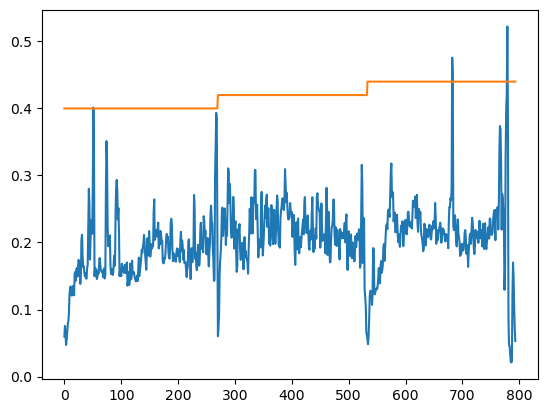

In [29]:
import matplotlib.pyplot as plt
plt.plot(train_features.sum(1))
plt.plot(train_labels/50+0.4)

In [30]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(penalty='l2', C=100).fit(train_features, train_labels)
reg.score(train_features, train_labels)

0.9748110831234257

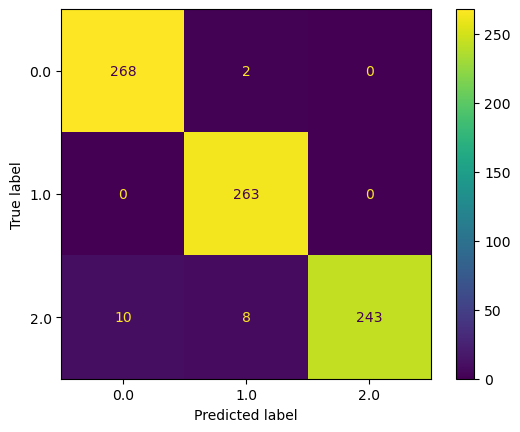

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(train_labels, reg.predict(train_features)), display_labels=reg.classes_)
disp.plot()

In [32]:
from joblib import dump, load 
#dump(reg,'LogisticRegression1.joblib') 

In [33]:

accuracy_list = []
accuracy_list += [reg.score(test_features, test_labels)]
accuracy_list

[0.9528535980148883]

In [34]:
import tensorflow as tf

model = tf.keras.Sequential([
    # 64 is the number of neurons in each hidden layer
    tf.keras.layers.Dense(64, activation='relu', input_shape=(train_features.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use this if train_labels are integers
              metrics=['accuracy'])

# Train the model
history = model.fit(train_features, train_labels, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on training and test data
train_loss, train_accuracy = model.evaluate(train_features, train_labels, verbose=0)
test_loss, test_accuracy = model.evaluate(test_features, test_labels, verbose=0)

print('Train accuracy:', train_accuracy)
print('Test accuracy:', test_accuracy)




Epoch 1/10
20/20 [==============================] - 1s 15ms/step - loss: 1.0690 - accuracy: 0.7638 - val_loss: 1.2124 - val_accuracy: 0.0000e+00
Epoch 2/10
20/20 [==============================] - 0s 4ms/step - loss: 1.0147 - accuracy: 0.7795 - val_loss: 1.3945 - val_accuracy: 0.0000e+00
Epoch 3/10
20/20 [==============================] - 0s 5ms/step - loss: 0.9480 - accuracy: 0.8000 - val_loss: 1.5968 - val_accuracy: 0.0000e+00
Epoch 4/10
20/20 [==============================] - 0s 5ms/step - loss: 0.8752 - accuracy: 0.8047 - val_loss: 1.6856 - val_accuracy: 0.0000e+00
Epoch 5/10
20/20 [==============================] - 0s 6ms/step - loss: 0.7884 - accuracy: 0.8047 - val_loss: 1.7094 - val_accuracy: 0.0000e+00
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 0.6986 - accuracy: 0.8047 - val_loss: 1.6757 - val_accuracy: 0.0000e+00
Epoch 7/10
20/20 [==============================] - 0s 10ms/step - loss: 0.6115 - accuracy: 0.8063 - val_loss: 1.6235 - val_accuracy: 0

26/26 [==============================] - 0s 2ms/step


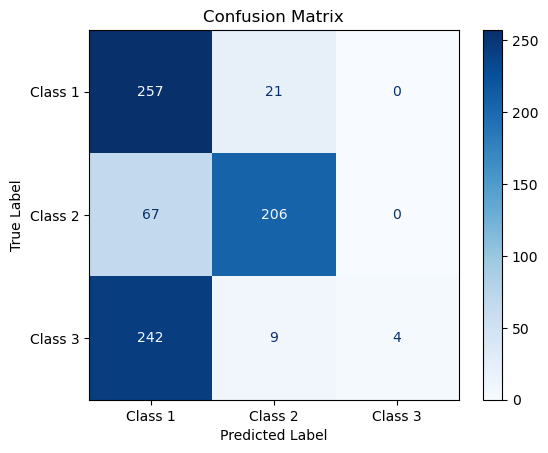

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions for the test data
predictions = np.argmax(model.predict(test_features), axis=1)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Define class labels (if not already defined)
class_labels = ['Class 1', 'Class 2', 'Class 3']  # Replace with your actual class labels if necessary

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)  # Adjust the colormap if needed
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [36]:
from joblib import dump, load
dump(model, 'ANN.joblib') 

['ANN.joblib']

In [37]:
import tensorflow as tf

train_features_reshaped = train_features.reshape(train_features.shape[0], train_features.shape[1], -1)
test_features_reshaped = test_features.reshape(test_features.shape[0], test_features.shape[1], -1)


# Define the RNN model
rnn_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64, activation='relu', input_shape=train_features_reshaped.shape[1:]),  # Use train_features_reshaped.shape[1:] as input shape
    tf.keras.layers.Dense(128, activation='relu'),  # Adding an additional dense layer with 128 units
    tf.keras.layers.Dense(128, activation='relu'),  # Adding another dense layer with 128 units
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the RNN model
rnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',  # Use this if train_labels are integers
                  metrics=['accuracy'])

# Train the RNN model
history = rnn_model.fit(train_features_reshaped, train_labels, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the RNN model on training and test data
train_loss, train_accuracy = rnn_model.evaluate(train_features_reshaped, train_labels, verbose=0)
test_loss, test_accuracy = rnn_model.evaluate(test_features_reshaped, test_labels, verbose=0)

print('Train accuracy:', train_accuracy)
print('Test accuracy:', test_accuracy)




Epoch 1/10
20/20 [==============================] - 3s 43ms/step - loss: 1.0587 - accuracy: 0.5087 - val_loss: 1.4524 - val_accuracy: 0.0000e+00
Epoch 2/10
20/20 [==============================] - 0s 14ms/step - loss: 0.7673 - accuracy: 0.7953 - val_loss: 2.2045 - val_accuracy: 0.0000e+00
Epoch 3/10
20/20 [==============================] - 0s 9ms/step - loss: 0.3924 - accuracy: 0.8283 - val_loss: 1.5269 - val_accuracy: 0.2830
Epoch 4/10
20/20 [==============================] - 0s 12ms/step - loss: 0.2456 - accuracy: 0.9197 - val_loss: 1.0320 - val_accuracy: 0.5346
Epoch 5/10
20/20 [==============================] - 0s 10ms/step - loss: 0.2016 - accuracy: 0.9134 - val_loss: 1.7573 - val_accuracy: 0.3145
Epoch 6/10
20/20 [==============================] - 0s 8ms/step - loss: 0.1679 - accuracy: 0.9354 - val_loss: 1.4184 - val_accuracy: 0.3962
Epoch 7/10
20/20 [==============================] - 0s 13ms/step - loss: 0.1736 - accuracy: 0.9244 - val_loss: 1.9463 - val_accuracy: 0.3333
Epoch 8

26/26 [==============================] - 0s 4ms/step


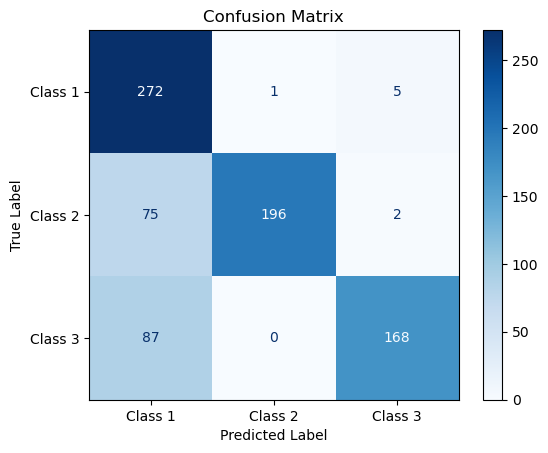

In [38]:
# Get predictions for the test data
predictions = np.argmax(rnn_model.predict(test_features), axis=1)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Define class labels (if not already defined)
class_labels = ['Class 1', 'Class 2', 'Class 3']  # Replace with your actual class labels if necessary

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)  # Adjust the colormap if needed
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [39]:
from joblib import dump, load
dump(model, 'RNN.joblib') 

['RNN.joblib']